# Overview

In this notebook we will be doing EDA as well as decomposing our Time Series Data into level, trend, seasonality, and noise components.

We do this becuase it provides us with a useful abstract model for thinking about the time series data. Naturally the Beijing Air Pollution dataset after our manipulations is not stationary, meaning the mean, variance, and covariance will be time dependent. We must identify and seperate trends and seasonality from time series data before applying a model.

### Import Libraries

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd #Basic library for all of our dataset operations
import numpy as np
import requests
import io
import statsmodels.tsa.api as smt
import statsmodels as sm
import tensorflow as tf
import pmdarima as pm
import warnings
import xgboost as xgb
import seaborn as sns

In [4]:
from math import sqrt

In [5]:
import gluonts

In [6]:
import shap #Game thoery approach to output of ML Model
warnings.filterwarnings("ignore") 

In [7]:
#from utils.metrics import evaluate
#from utils.plots import bar_metrics

In [8]:
from statsmodels.tsa.ar_model import AR
from random import random
from datetime import datetime
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

Importing plotly failed. Interactive plots will not work.


In [9]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn import linear_model, svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV

In [10]:
from math import sqrt
from xgboost import plot_importance, plot_tree
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from itertools import islice
from pylab import rcParams

In [11]:
from tqdm import tqdm, tqdm_notebook
from bayes_opt import BayesianOptimization

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

### Read Data

In [12]:
air_pollution = pd.read_csv('pollution.csv', parse_dates = ['date'])
air_pollution.set_index('date', inplace = True)
air_pollution.sort_index(inplace = True)
air_pollution.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
date,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,10.041667
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333


In [13]:
air_pollution.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
count,1789.000000,1789.000000,1789.000000,1789.000000,1789.000000,1789.000000,1789.000000,1789.000000
mean,95.905347,1.840763,12.478643,1016.414128,23.781213,0.053824,0.197294,95.905347
std,76.936876,14.152628,11.519263,10.069192,41.064874,0.551490,1.001634,76.936876
min,1.875000,-33.333333,-14.458333,994.041667,1.412500,0.000000,0.000000,1.875000
25%,39.791667,-10.083333,1.583333,1007.916667,5.847083,0.000000,0.000000,39.791667
50%,76.250000,2.000000,13.916667,1016.125000,10.948750,0.000000,0.000000,76.250000
75%,127.875000,15.083333,23.166667,1024.541667,22.111250,0.000000,0.000000,127.875000
max,529.458333,26.208333,32.875000,1043.458333,463.187917,14.166667,17.583333,529.458333


### Analysis and Transforms

We will be touching on:
- Time Series decomposition
 - Level
 - Trend
 - Seasonality
 - Noise
- Stationary
 - AC and PAC plots
 - Rolling mean and std.
 - Dickey- Fuller Test
- Making our time series stationary
 - Difference transform
 - Log scale
 - Smoothing
 - Moving Average

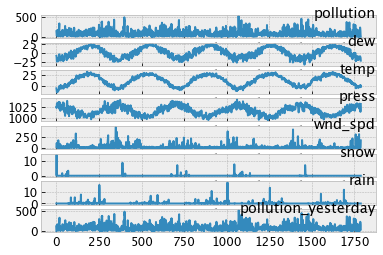

In [14]:
values = air_pollution.values
groups = [0, 1, 2, 3, 4, 5, 6, 7]

i = 1
#plot each column
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(air_pollution.columns[group], y = 0.6, loc = 'right')
    i += 1
    
plt.show()

Check to see how the graph behaves with each feature

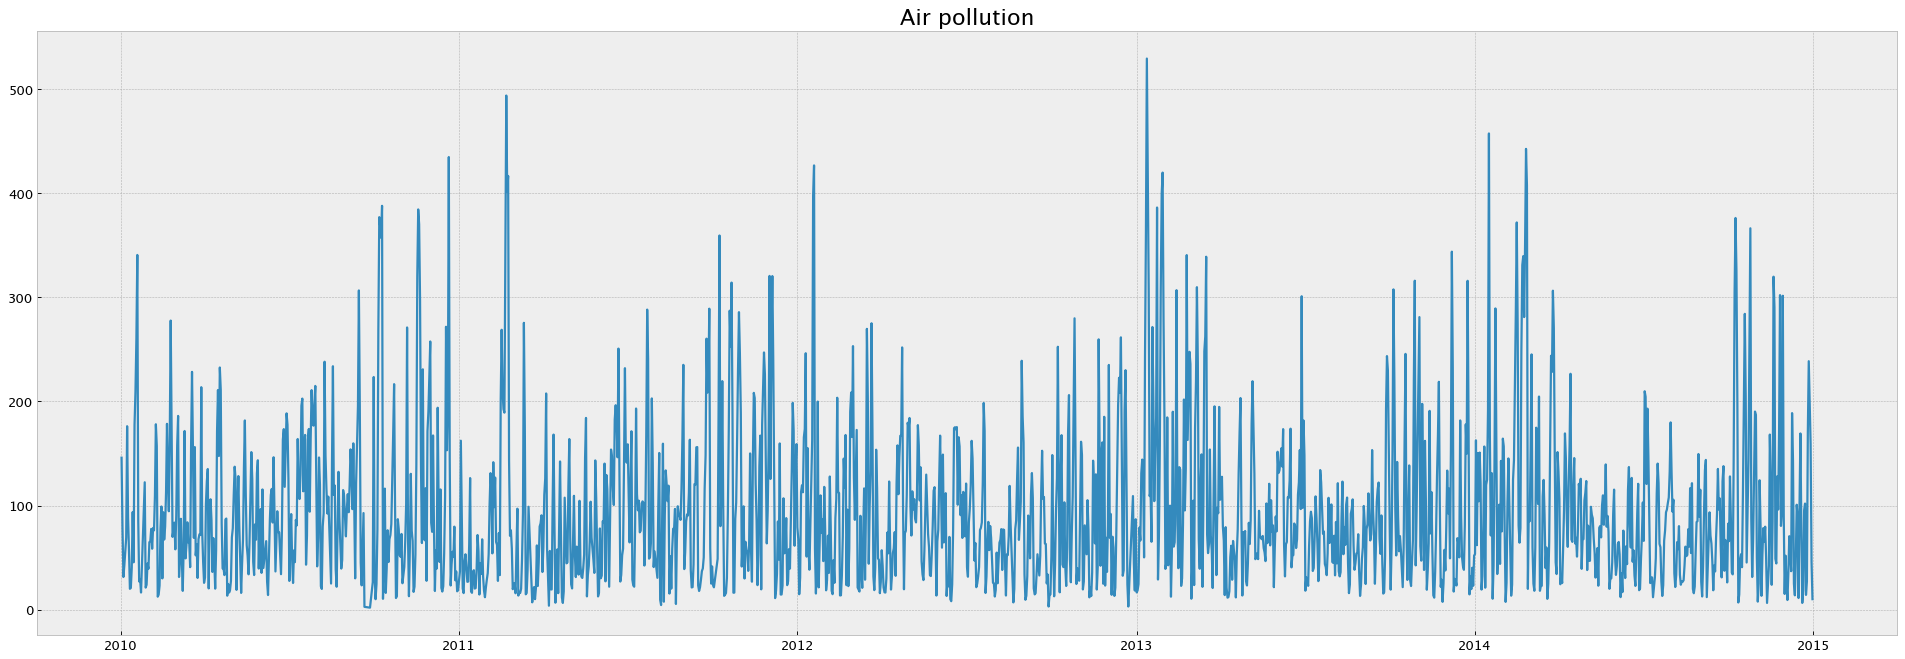

In [15]:
fig, ax = plt.subplots(num=None, figsize=(30, 10), dpi=80)
plt.title('Air pollution',fontsize=20)

plt.plot(air_pollution.pollution)

plt.show()
#plt.savefig("results/pollution.png")

### Decomposing our Time Series

As we mentioned earlie we are going to decompose your time series into 4 parts: level, trend, seasonality and noise. We will talk about what this means latter in the notebook.

Two structures for basic decomposition models:

##### Addiditve model y(t) = Level + Trend + Seasonal + Noise(random)

The additive model is useful when the seasonal variation is constant over time. Additive models are linear.

##### Multiplicative  model  y(t) = Level * Trend * Seasonal * Noise(random)


The multiplicative model is useful when the seasonal variation increases over time. Multiplicative models are nonlinear. 

##### Automatic Time Series decomposition

Statsmodel python library provides a function seasonal_compose() to automatically decompose a time series, we just need to specify whether it is additive or multiplicative. We will use multiplicative as our model 

<Figure size 6400x4800 with 0 Axes>

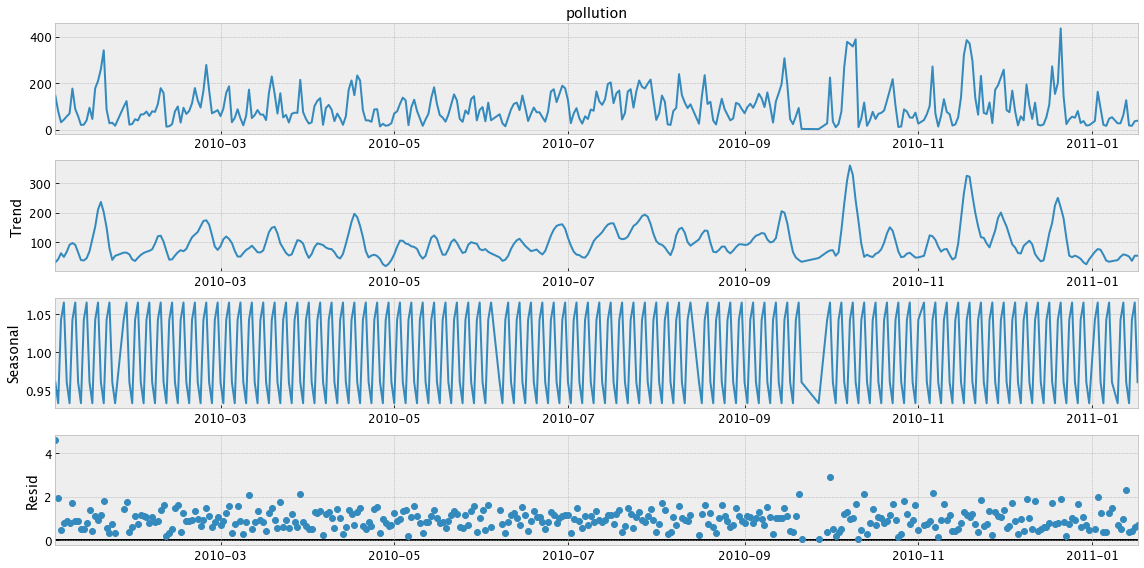

In [16]:
rcParams['figure.figsize'] = 16, 8
plt.figure(num=None, figsize=(80, 60), dpi=80, facecolor='w', edgecolor='k')
series = air_pollution.pollution[:365]
result = seasonal_decompose(series, model='multiplicative', extrapolate_trend = 'freq', period = 4)
result.plot()
pass

##### Level

Level just means the current value of the series once Trend, seasonality, and noise are removed. Most models will benefit from our time series that is composed by level and not by trends/seasonality/noise.

##### Trend 

The trend component refers to the pattern in the data that spans across seasonal periods. We are looking for a decreasing or increasing slope in the time series. A trend is a smooth, general, long-term, average tendency. 

Trend can be removed from the time series data in theory, but it does not always improve the results of our model. 

Identifying trends can be a subjective process becuase we are not sure if our component contains seasonalities or noise to it, thus we will create line plots and observe below.

We will check for:
- Automatic decomposing
- Moving average
- Fitting a linear regression model

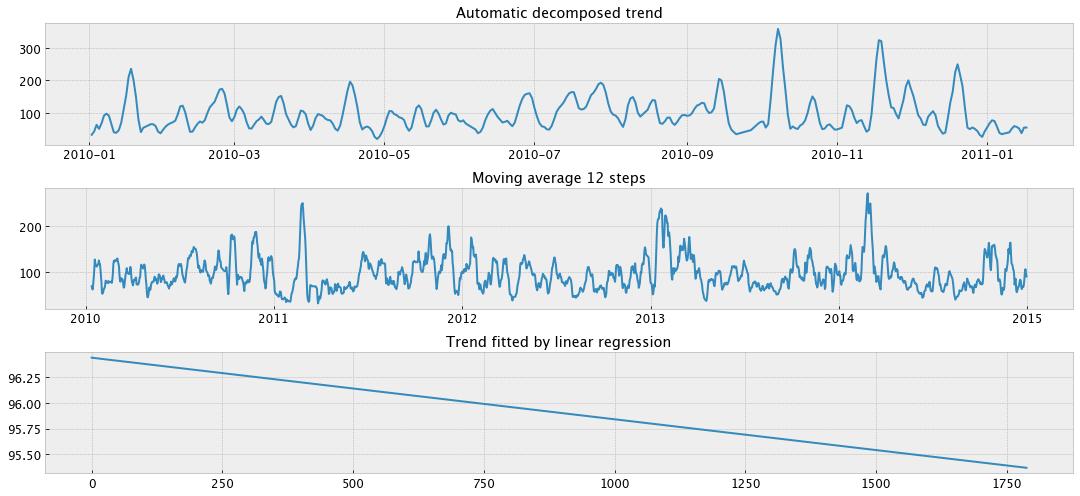

In [17]:
fig = plt.figure(figsize=(15, 7))
layout = (3,2)
pm_ax = plt.subplot2grid(layout, (0,0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1,0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2,0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = air_pollution.pollution.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(air_pollution))]
X = np.reshape(X, (len(X), 1))
y = air_pollution.pollution.values
model = LinearRegression()
model.fit(X, y)

# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

We can see our series does not have a strong trend, results from both the automatic decomposition and the moving average look more like a seasonality + noise effect, than a trend. This sort of confirmed with our linear regression, which cant find our series properly and gives us a poor trend.

We could also try to split our series into smaller ones to try identify subtrends with the mentioned methods but we will not be doing so.

##### Seasonality

The seasonality component explains the periodic ups and downs you see in the dataset. around 2010-10 and 2011-01 the pollution levels are at their highest.

Doing a little further research China usually has a big problem with smog/air pollution during winter months. The coldness of the winter months means that more coal and other fossil feuls are burnt during this time of year.

Lets try decomposing seasonality into smaller parts becuase the automatic decomposing chart did not give us a good look into decomposed seasonality.

We saw the first year of data previously.

Lets check for last year of data:

<Figure size 4000x1600 with 0 Axes>

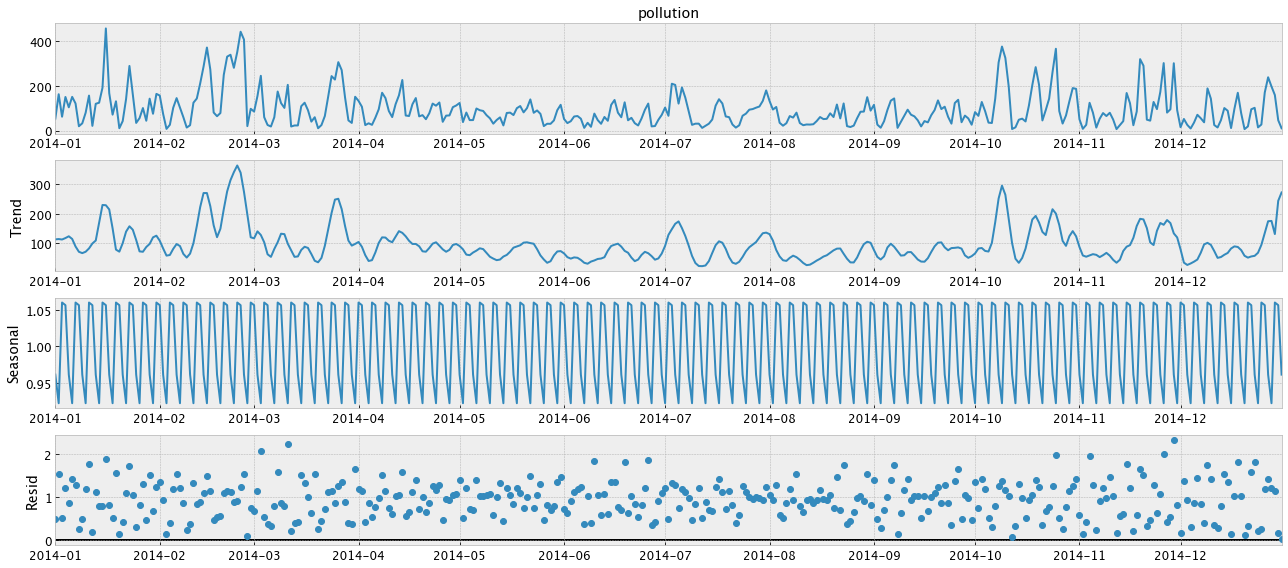

In [18]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = air_pollution.pollution[-365:]
result = seasonal_decompose(series, model='multiplicative', extrapolate_trend = 'freq', period = 4)
result.plot()
pass

Here we see seasonality but a bit different that the first year of data.

We dig even further and try to find weekly seasonality

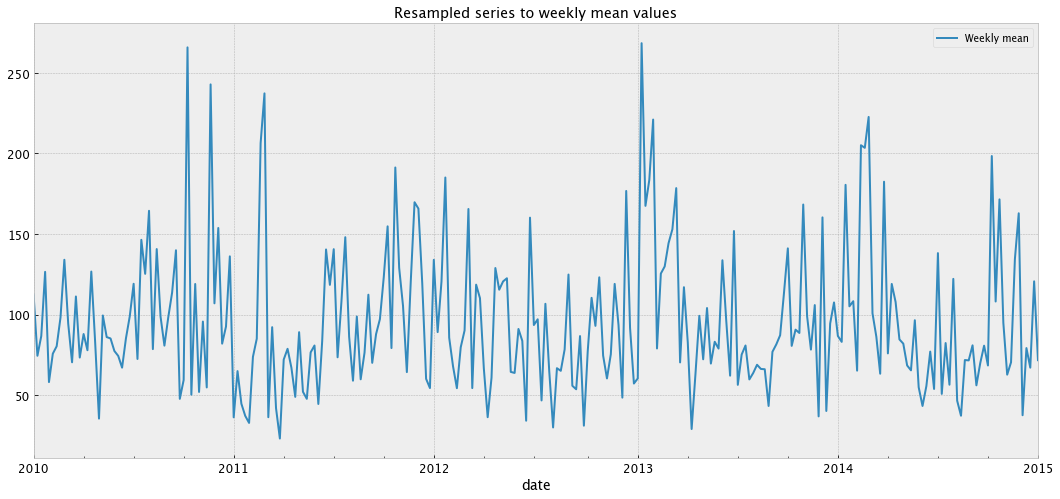

In [19]:
#Looking for weekly seasonality
resample = air_pollution.resample('W')
weekly_mean = resample.mean()
weekly_mean.pollution.plot(label='Weekly mean')
plt.title("Resampled series to weekly mean values")
plt.legend()

We can also model the season component directly, then subtract it from the observations.

Once fit, the model can then be used to calculate a seasonal component for any time index. In this case of pollution data, the time index would be the day of the year. We could then estiamte the seasonal component for the day of the year for any historical observations or any new observations.

We will be using a simple polynomial model for this.


In [20]:
ts = air_pollution.pollution.values
X = [i%365 for i in range(0, len(ts))]
y = series
degree = 100
coef = np.polyfit(X, y, degree)

# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)

# plot curve over original data
plt.plot(series,label='Original')
plt.plot(curve, color='red', linewidth=3,label='polynomial model')
plt.legend()
plt.title("Polynomial fit to find seasonality")
plt.show()

TypeError: expected x and y to have same length

The curve appears to be a bad fit for the seasonal structure in the dataset. We will not use this model to create a seasonally adjusted version of the dataset.

##### Noise

Noise or the random component is what remains behind when we seperate out seasonality and trend from the time series. It is the effect of factors that we do not know, or we cannot measure.

Lets check to see if we can distinguish if we have noise.

Text(0.5, 1.0, 'Mean over time')

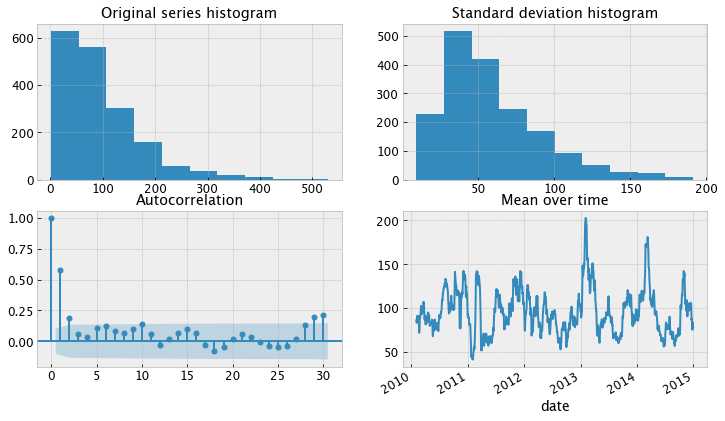

In [21]:
fig = plt.figure(figsize=(12, 7))
layout = (2,2)
hist_ax = plt.subplot2grid(layout, (0,0))
ac_ax = plt.subplot2grid(layout, (1,0))
hist_std_ax = plt.subplot2grid(layout, (0,1))
mean_ax = plt.subplot2grid(layout, (1,1))

air_pollution.pollution.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

plot_acf(series, lags = 30,ax = ac_ax)
ac_ax.set_title("Autocorrelation")

mm = air_pollution.pollution.rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = air_pollution.pollution.rolling(30).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

Our series does not follow a Gaussian distriubtion from the histogram or the standard deviation, though the std. does have a mean that is more centered. 

We also ahve a small correlation with close measurements in time but that is it. 

Overall we could say that we do have a little noise but maybe not enough that we need to remove it.

###### Stationarity

Stationarity is one of the most important characterstics of time series. If a time series has a constant mean and variance over time then it is stationary. It is imperative to modelling becuase most models only work with stationary data.

Lets check for stationarity.

We can use Autocorrelation and partial autocorrelation plots. These represent the strenght of a relationship with an observation in a time series with observations at prior time steps. Confusing right?
Basically its how correlated are values at time t with the next values t, t + 1, t + 2, ..., t + n.

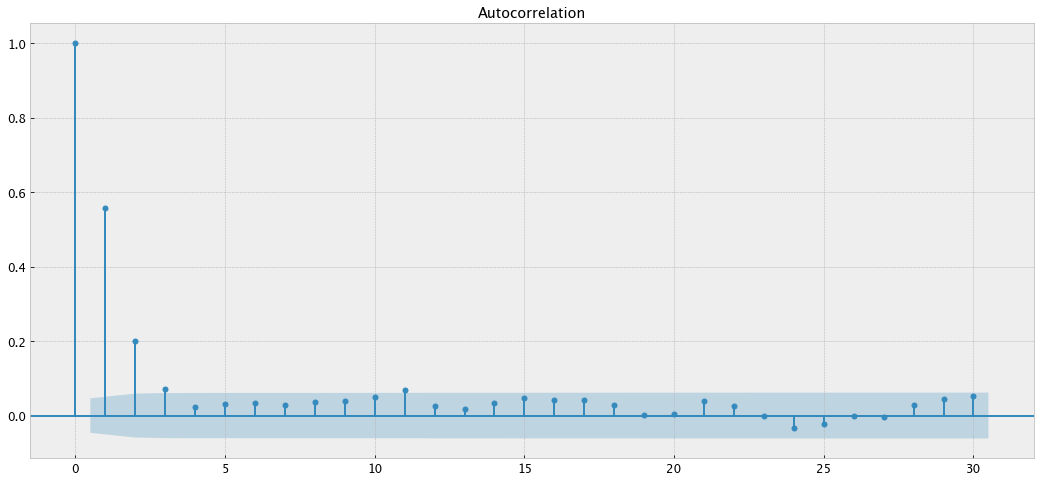

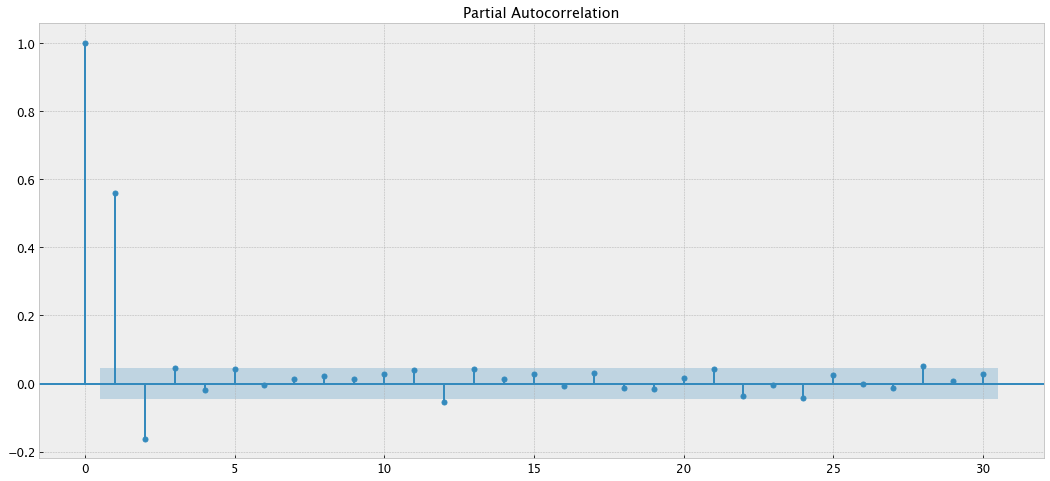

In [22]:
plot_acf(ts, lags = 30)
plot_pacf(ts, lags = 30)
plt.show()

We see that our time series values are not correlated with distnant point in times. This should mean that our daty is stationary from a first glance.

Lets confirm this.

##### Rolling means and standard deviation of our series

We mentioned that our mean and standard deviation have to constant over time in order for our data to be stationary. We will plot both rolling mean and rolling std.

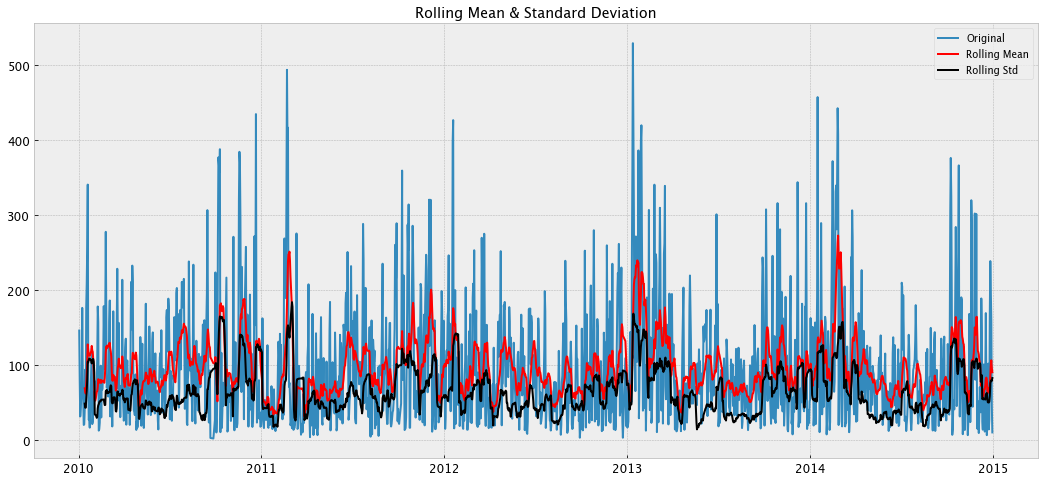

In [23]:
#Determing rolling statistics
rolmean = air_pollution.pollution.rolling(window=12).mean()
rolstd = air_pollution.pollution.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(air_pollution.pollution,label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

From the graph we can tell that our rolling mean and our rolling std are constant over time, indicating that our data is stationary.

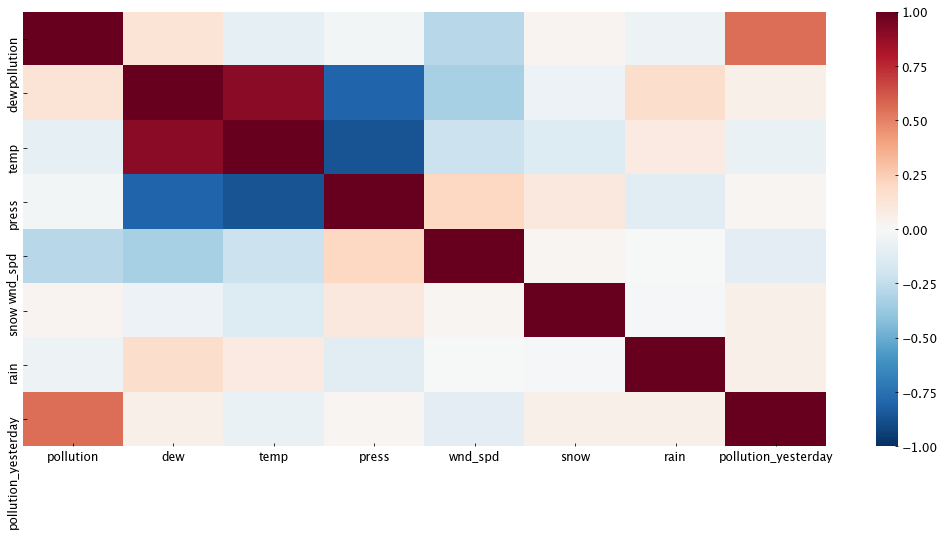

In [24]:
corr = air_pollution.corr()
sns.heatmap(corr, vmin = -1, vmax = 1, cmap= 'RdBu_r');

###### One final test: The Dickey- Fuller test

The Dickey-Fuller test is called a unit root test. The basis behind a unit root test is that it determines how strongly a time series is defined by a trend. The presence of a unit root means the time series is non-stationary. The test uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): assumes the presence of a root, that is alpha = 1, meaning it is non-stationary. It has some time dependent structure. The p-value should be less tahn the significance level (0.05) in order to reject the null hypothesis.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure. A p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary. p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary. 

In [25]:
X = air_pollution.pollution.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.494973
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Our p-value is less than 0.05 so we reject the null hypothesis and say taht our data does not contain a unit root and hence is staionary.

Lets consolidate everything.

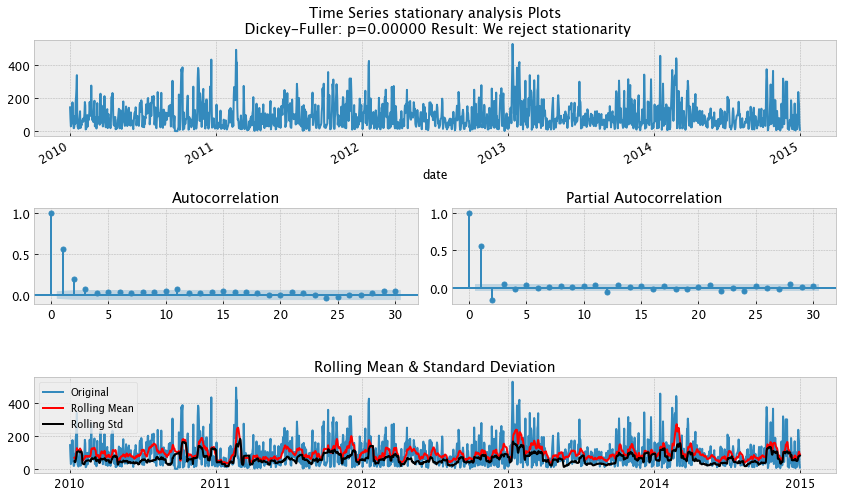

In [26]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        mean_std_ax = plt.subplot2grid(layout, (2,0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value<=0.05 else "We can not reject stationarity"
        ts_ax.set_title('Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value,hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
        rolmean = air_pollution.pollution.rolling(window=12).mean()
        rolstd = air_pollution.pollution.rolling(window=12).std()

        #Plot rolling statistics:
        orig = plt.plot(air_pollution.pollution,label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        
        
tsplot(air_pollution.pollution, lags=30)
plt.savefig("results/pollution.png")

We thankfully didn't have to make everything stationary but if we did it would not be too difficult. We would have to apply a difference transform to remove series dependance on time. Then we would do a log scale transformation as well, smooth it out and bam we should be all stationaried out :).